In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpi

In [4]:
import glob
import tqdm

In [5]:
letters = {}
from string import ascii_lowercase
for c in ascii_lowercase:
    letters[c] = c;
del letters['j']
del letters['z']
letters = sorted(list(letters))

In [6]:
def collectImages(letter):
    speakers = ['A', 'B', 'C', 'D', 'E']
    data = []
    for s in speakers:
            image_path = 'dataset5/' + s + '/' + letter + '/'
            names = glob.glob(image_path + "*.*")
            for name in names[:1]:
                image = cv2.imread(name)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                h = image.shape[0]
                w = image.shape[1]
                if h > w:
                    if (w/h > 0.8):
                        k = int((h - w) / 2)
                        image = image[k:-k-1, :]
                    else:
                        image = image[int(0.1*h): -int(0.1*h)-1, :]
                if h < w:
                    if (h/w > 0.8):
                        k = int((w - h) / 2)
                        image = image[:, k:-k-1]
                    else:
                        image = image[:, int(0.1*h): -int(0.1*h)-1]
                image = cv2.resize(image, (128, 128))
                data.append(image)
    return data

In [7]:
len(letters)

24

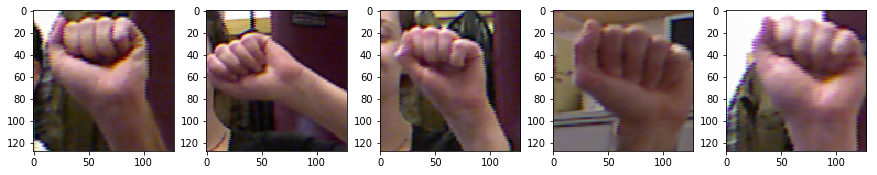

In [8]:
data = collectImages('a')
plt.figure(figsize=(15 ,15))
for i in range(len(data)):
    plt.subplot(5, 5, i + 1)
    imgplot = plt.imshow(data[i])
plt.show()


cv2.startWindowThread()
cv2.namedWindow("image")
cv2.imshow('image',data[1])
cv2.waitKey()
cv2.destroyAllWindows()

In [9]:
hog_descriptor = cv2.HOGDescriptor((64, 64), #winsize
                                    (16, 16), #blocksize
                                    (8, 8), #blockstride
                                    (8, 8),   #cellsize
                                    9)        #nbins

In [10]:
f = hog_descriptor.compute(data[0]).T

In [11]:
HOGSIZE = 142884
dim1 = 252
dim2 = 189
dim3 = 3
# dim1 * dim2 * dim3 = HOGSIZE
HOGSHAPE = (dim1, dim2, dim3)
ANS_SIZE = len(letters) # =24
#IMG_COUNT = precountSize()
IMG_COUNT = 24*5

In [12]:
def precountSize():
    speakers = ['A', 'B', 'C', 'D', 'E']
    result = 0
    for l in letters:
        for s in speakers:
            image_path = 'dataset5/' + s + '/' + l + '/'
            names = glob.glob(image_path + "*.*")
            result += len(names)
    return result

In [13]:
X = np.empty((IMG_COUNT, dim1, dim2, dim3))
Y = np.empty((IMG_COUNT, 1))
cur = 0
for i in range(len(letters)):
    Ldata = collectImages(letters[i])
    #Answer = np.zeros(ANS_SIZE)
    #Answer[i] = 1
    
    for Im in Ldata:
        X[cur] = np.reshape(hog_descriptor.compute(Im), HOGSHAPE)
        Y[cur] = i
        cur += 1

In [14]:
from keras.utils import to_categorical
print(Y.shape)
Y = to_categorical(Y, num_classes=ANS_SIZE)
print(Y.shape)

Using TensorFlow backend.


(120, 1)
(120, 24)


In [15]:
random_order = np.random.permutation(X.shape[0])
Y.astype('float32')
x_shuffle = []
y_shuffle = []
for i in random_order:
    x_shuffle.append(X[i])
    y_shuffle.append(Y[i])
X = np.array(x_shuffle) 
Y = np.array(y_shuffle)
split = int(round(0.2*len(Y)))
x_train = X[split:]
y_train = Y[split:]
x_test = X[:split]
y_test = Y[:split]

In [16]:
from keras.models import Sequential
from keras.models import Model
from keras import applications
from keras import optimizers
from keras.layers import Dropout, Flatten, Dense

In [17]:
from keras.applications import InceptionV3
basic = applications.InceptionV3(weights='imagenet', include_top=False, input_shape=HOGSHAPE)

In [18]:
newmodel = Sequential()
newmodel.add(Flatten(input_shape = basic.output_shape[1:]))
newmodel.add(Dense(3072, activation='relu'))
newmodel.add(Dense(192, activation='relu'))
newmodel.add(Dense(24, activation='relu'))
newmodel.summary()
final = Model(inputs = basic.input, outputs = newmodel(basic.output))
final.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])
#final.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 49152)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 3072)              150998016 
_________________________________________________________________
dense_2 (Dense)              (None, 192)               590016    
_________________________________________________________________
dense_3 (Dense)              (None, 24)                4632      
Total params: 151,592,664
Trainable params: 151,592,664
Non-trainable params: 0
_________________________________________________________________


In [19]:
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

b_size = 16
eps = 30

from keras_tqdm import TQDMNotebookCallback

In [ ]:
datagen = ImageDataGenerator()
final.fit_generator(
    datagen.flow(x_train, y_train, batch_size=b_size),
    steps_per_epoch=x_train.shape[0] // b_size,
    epochs=eps,
    validation_data=(x_test, y_test),
    callbacks=[ModelCheckpoint('HandsRecognition.model', monitor='val_acc', save_best_only=True), TQDMNotebookCallback()],
    verbose = 2
)

Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Epoch 1/30


base_model = applications.InceptionV3(weights=None, include_top=False, input_shape=HOGSIZE)
add_model = Sequential()
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(Dense(256, activation='relu'))
add_model.add(Dense(24, activation='sigmoid'))

model = Model(inputs=base_model.input, outputs=add_model(base_model.output))
model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

batch_size = 32
epochs = 50

train_datagen = ImageDataGenerator(
        rotation_range=30, 
        width_shift_range=0.1,
        height_shift_range=0.1, 
        horizontal_flip=True)
train_datagen.fit(x_train)


history = model.fit_generator(
    train_datagen.flow(x_train, y_train, batch_size=batch_size),
    steps_per_epoch=x_train.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    callbacks=[ModelCheckpoint('mod.model', monitor='val_acc', save_best_only=True)]
)

#model.fit(x_train, y_train, batch_size=b_size, epochs = 30, verbose = 1)

In [ ]:
score = model.predict(x_test, y_test, batch_size=b_size)